## Install the necessary python libraries

In [174]:
!pip install networkx pandas numpy matplotlib

import networkx as nx
import numpy as np
from networkx.algorithms import isomorphism
import matplotlib.pyplot as plt

# VF2 
## Undirected graph

In [175]:
# Generate 2 graphs
G1 = nx.Graph()
G2 = nx.Graph()

G1.add_nodes_from(range(0,9))
G2.add_nodes_from(range(0,9))
G1.add_edges_from([(0,1), (1,2), (2,3), (3,4), (2,5), (5,6), (6, 8), (6, 9), (7, 9)])
G2.add_edges_from([(0,1), (1,4), (2,4), (2,6), (4,3), (3,5), (5, 9), (5, 8), (7, 8)])

# Mapping 2 graph G1 and G2
GM = isomorphism.GraphMatcher(G2,G1)
print(f" Checking graph isomorphic: {GM.is_isomorphic()}")
GM.mapping

 Checking graph isomorphic: True


{0: 0, 1: 1, 4: 2, 2: 3, 6: 4, 3: 5, 5: 6, 9: 8, 8: 9, 7: 7}

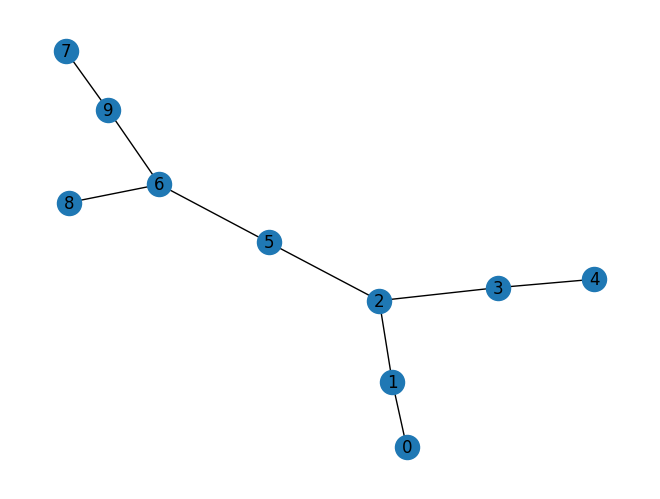

In [176]:
nx.draw(G1, with_labels = True)

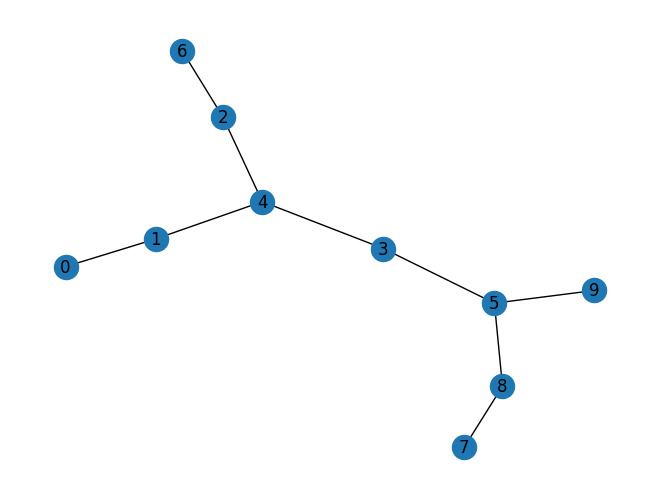

In [177]:
nx.draw(G2, with_labels = True)

## Directed graph

In [178]:
# Generate 2 directed graphs
G1 = nx.DiGraph()
G2 = nx.DiGraph()

G1.add_nodes_from(range(0,9))
G2.add_nodes_from(range(0,9))
G1.add_edges_from([(0,1), (1,2), (2,3), (3,4), (2,5), (5,6), (6, 8), (6, 9), (7, 9)])
G2.add_edges_from([(0,1), (1,4), (2,4), (2,6), (4,3), (3,5), (5, 9), (5, 8), (7, 8)])

# Mapping 2 graph G1 and G2
GM = isomorphism.GraphMatcher(G2,G1)
print(f" Checking graph isomorphic: {GM.is_isomorphic()}")
GM.mapping

 Checking graph isomorphic: False


{}

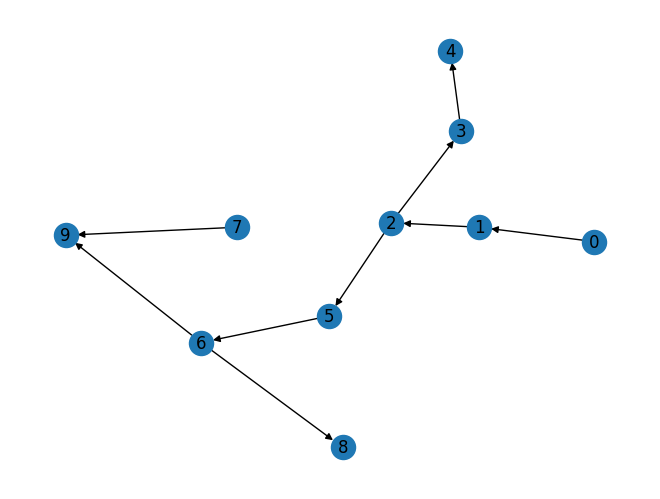

In [186]:
nx.draw(G1, with_labels = True)

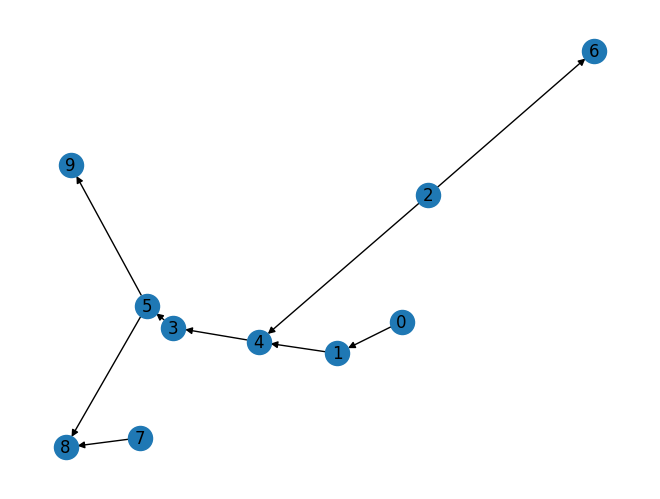

In [188]:
nx.draw(G2, with_labels = True)

## Update the mismatch edge

In [193]:
# Generate 2 directed graphs
G1 = nx.DiGraph()
G2 = nx.DiGraph()

G1.add_nodes_from(range(0,9))
G2.add_nodes_from(range(0,9))
# Change graph edges
G1.add_edges_from([(0,1), (1,2), (2,3), (3,4), (2,5), (5,6), (6, 8), (6, 9), (7, 9)])
G2.add_edges_from([(0,1), (1,4), (4,2), (2,6), (4,3), (3,5), (5, 9), (5, 8), (7, 8)])

# Mapping 2 graph G1 and G2
GM = isomorphism.GraphMatcher(G2,G1)
print(f" Checking graph isomorphic: {GM.is_isomorphic()}")
GM.mapping

 Checking graph isomorphic: True


{0: 0, 1: 1, 4: 2, 2: 3, 6: 4, 3: 5, 5: 6, 9: 8, 8: 9, 7: 7}

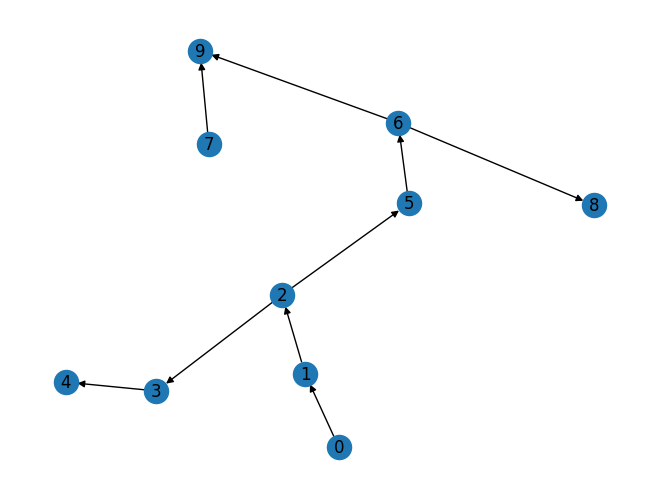

In [203]:
nx.draw(G1, with_labels = True)

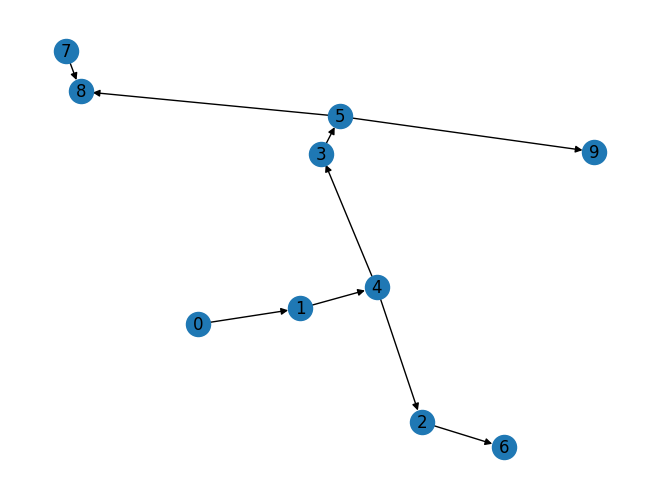

In [213]:
nx.draw(G2, with_labels = True)

# VF2++

Citation: Jüttner, Alpár, and Péter Madarasi. "VF2++—An improved subgraph isomorphism algorithm." Discrete Applied Mathematics 242 (2018): 69-81.

The VF2++ algorithm, follows a similar logic to that of VF2, while also introducing new easy-to-check cutting rules and determining the optimal access order of nodes. It is also implemented in a non-recursive manner, which saves both time and space, when compared to its previous counterpart.

The main reason for the superiority of VF2++ over VF2 is twofold. Firstly, taking into account the structure and the node labeling of the graph, VF2++ determines a matching order in which most of the unfruitful branches of the search space can be pruned immediately. Secondly, introducing more efficient — nevertheless still easier to compute — cutting rules reduces the chance of going astray even further.

## Algorithms:

Algorithm 2 is a high-level description of the matching order procedure of VF2++. It computes a BFS tree for each component in ascending order of their rarest node labels and largest degree, whose root vertex is the minimal node of its component. 
![image info](./data/VF2++_2.jpg)

Algorithm 3 is a method to process a level of the BFS tree, which appends the nodes of the current level in descending lexicographic order.
![image info](./data/VF2++_3.jpg)

In [214]:
# Generate 2 graphs
G1 = nx.Graph()
G2 = nx.Graph()

G1.add_nodes_from(range(0,9))
G2.add_nodes_from(range(0,9))
G1.add_edges_from([(0,1), (1,2), (2,3), (3,4), (2,5), (5,6), (6, 8), (6, 9), (7, 9)])
G2.add_edges_from([(0,1), (1,4), (2,4), (2,6), (4,3), (3,5), (5, 9), (5, 8), (7, 8)])


check_isomorphic = nx.vf2pp_is_isomorphic(G1, G2, node_label=None)
print(f" Checking graph isomorphic: {check_isomorphic}")

# Mapping 2 graph G1 and G2
nx.vf2pp_isomorphism(G1, G2, node_label=None)

 Checking graph isomorphic: True


{2: 4, 1: 1, 3: 2, 5: 3, 6: 5, 0: 0, 4: 6, 9: 8, 8: 9, 7: 7}

## Graph with labels

In [215]:
G1 = nx.Graph()
G2 = nx.Graph()

G1.add_edges_from([(0,1), (1,2), (2,3), (3,4), (2,5), (5,6), (6, 8), (6, 9), (7, 9)])
G2.add_edges_from([(0,1), (1,4), (2,4), (2,6), (4,3), (3,5), (5, 9), (5, 8), (7, 8)])

mapped = {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}
label_list = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "K"]

# ADD labels as node attributes
nx.set_node_attributes(G1, dict(zip(G1, label_list)), "label")
nx.set_node_attributes(G2, dict(zip([mapped[u] for u in G1], label_list)), "label")

check_isomorphic = nx.vf2pp_is_isomorphic(G1, G2, node_label="label")
print(f" Checking graph isomorphic: {check_isomorphic}")

# Mapping 2 graph G1 and G2
nx.vf2pp_isomorphism(G1, G2, node_label="label")

 Checking graph isomorphic: False


{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 8: 'H', 9: 'I', 7: 'K'}


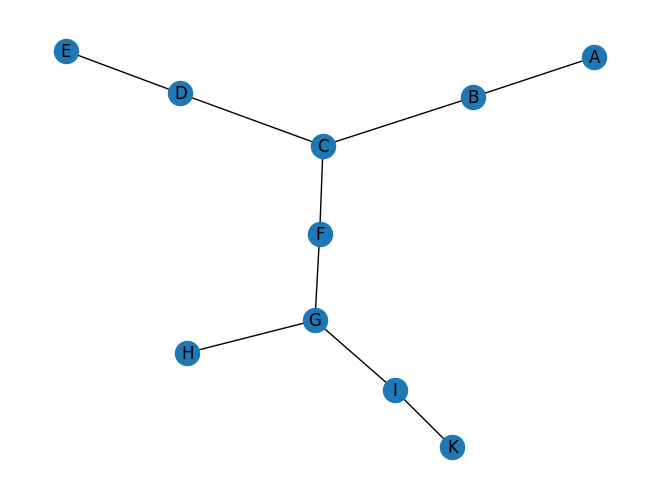

In [216]:
def draw_graph_with_labels(graph):
    labels = dict()
    names = nx.get_node_attributes(graph, 'label')
    print(names)
    for node in graph.nodes:
        labels[node] = f"{names[node]}"
    nx.draw(graph, labels=labels)
    

draw_graph_with_labels(G1)

{0: 'A', 1: 'B', 4: 'E', 2: 'C', 6: 'G', 3: 'D', 5: 'F', 9: 'I', 8: 'H', 7: 'K'}


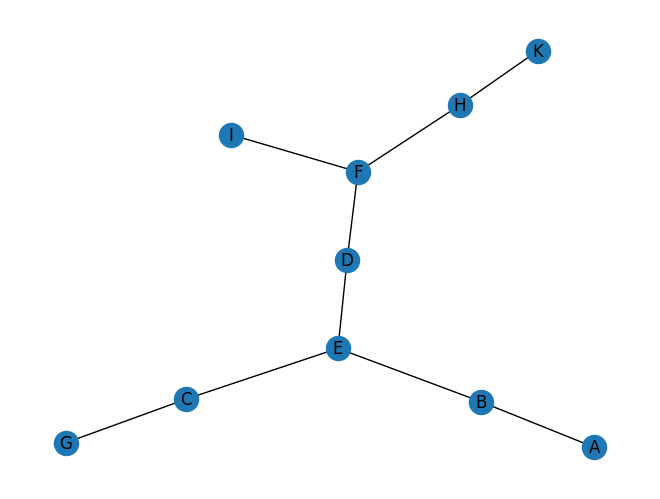

In [217]:
draw_graph_with_labels(G2)

In [218]:
G1 = nx.Graph()
G2 = nx.Graph()

# Create 2 similar graphs
G1.add_edges_from([(0,1), (1,2), (2,3), (3,4), (2,5), (5,6), (6, 8), (6, 9), (7, 9)])
G2.add_edges_from([(0,1), (1,2), (2,3), (3,4), (2,5), (5,6), (6, 8), (6, 9), (7, 9)])

mapped = {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}
label_list = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "K"]

# ADD labels as node attributes
nx.set_node_attributes(G1, dict(zip(G1, label_list)), "label")
nx.set_node_attributes(G2, dict(zip([mapped[u] for u in G1], label_list)), "label")

check_isomorphic = nx.vf2pp_is_isomorphic(G1, G2, node_label="label")
print(f" Checking graph isomorphic: {check_isomorphic}")

 Checking graph isomorphic: True


# VF2++ in different graphs
Comparing the graph on the left L and the graph on the right R
![image info](./data/example_isomorphic.png)

In [219]:
# Create graph L
L = nx.Graph(
    [
        ("a", "g"),
        ("a", "h"),
        ("a", "i"),
        ("g", "b"),
        ("g", "c"),
        ("b", "h"),
        ("b", "j"),
        ("h", "d"),
        ("c", "i"),
        ("c", "j"),
        ("i", "d"),
        ("d", "j"),
    ]
)

# Create graph R
R = nx.Graph(
    [
        (1, 2),
        (1, 5),
        (1, 4),
        (2, 6),
        (2, 3),
        (3, 7),
        (3, 4),
        (4, 8),
        (5, 6),
        (5, 8),
        (6, 7),
        (7, 8),
    ]
)

## Use VF2++ without considering node labels

In [220]:
check = nx.vf2pp_is_isomorphic(L, R, node_label=None)
print(f"Checking graph isomorphic: {check}")

# Graph Mapping
nx.vf2pp_isomorphism(L, R, node_label=None)

Checking graph isomorphic: True


{'i': 1, 'a': 2, 'c': 4, 'd': 5, 'g': 3, 'h': 6, 'j': 8, 'b': 7}

## Use VF2++ considering node labels

In [221]:
# Assign label to each node
L_node_attributes = {
    "a": "blue",
    "g": "green",
    "b": "pink",
    "h": "red",
    "c": "yellow",
    "i": "orange",
    "d": "cyan",
    "j": "purple",
}

# Set node labels by using node attributes
nx.set_node_attributes(L, L_node_attributes, name="color")

# Assign label to each node
R_node_attributes = {
    1: "blue",
    2: "red",
    3: "cyan",
    4: "orange",
    5: "green",
    6: "pink",
    7: "purple",
    8: "yellow",
}

# Set node labels by using node attributes
nx.set_node_attributes(R, R_node_attributes, name="color")

check = nx.vf2pp_is_isomorphic(L, R, node_label="color")
print(f"Checking graph isomorphic: {check}")

# Graph Mapping
nx.vf2pp_isomorphism(L, R, node_label="color")

Checking graph isomorphic: True


{'i': 4, 'a': 1, 'c': 8, 'd': 3, 'g': 5, 'h': 2, 'j': 7, 'b': 6}

# Weisfeiler Lehman (WL) graph hash
The function iteratively aggregates and hashes neighbourhoods of each node. After each node’s neighbors are hashed to obtain updated node labels, a hashed histogram of resulting labels is returned as the final hash.

Hashes are identical for isomorphic graphs and strong guarantees that non-isomorphic graphs will get different hashes.

In [222]:
G1 = nx.Graph()
G1.add_edges_from(
    [
        (1, 2, {"label": "A"}),
        (2, 3, {"label": "A"}),
        (3, 1, {"label": "A"}),
        (1, 4, {"label": "B"}),
    ]
)
G1_node_attributes = {
    1: "A",
    2: "B",
    3: "C",
    4: "D",
}
# Set node labels by using node attributes
nx.set_node_attributes(G1, G1_node_attributes, name="label")

G2 = nx.Graph()
G2.add_edges_from(
    [
        (5, 6, {"label": "B"}),
        (6, 7, {"label": "A"}),
        (7, 5, {"label": "A"}),
        (7, 8, {"label": "A"}),
    ]
)
G2_node_attributes = {
    5: "E",
    6: "F",
    7: "G",
    8: "H",
}
# Set node labels by using node attributes
nx.set_node_attributes(G2, G2_node_attributes, name="label")


{1: 'A', 2: 'B', 3: 'C', 4: 'D'}


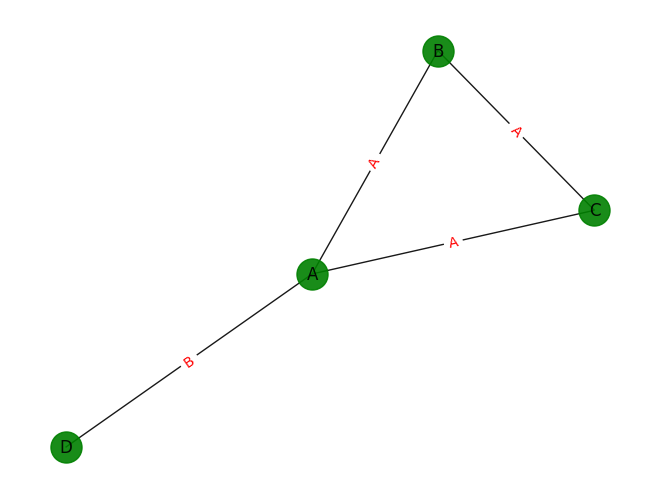

In [223]:
def draw_graph_with_labels(G):
    labels = dict()
    names = nx.get_node_attributes(G, 'label')
    print(names)
    for node in G.nodes:
        labels[node] = f"{names[node]}"
    pos = nx.spring_layout(G)
    plt.figure()
    nx.draw(
        G, pos, edge_color='black', width=1, linewidths=1,
        node_size=500, node_color='green', alpha=0.9,
        labels=labels
    )
    nx.draw_networkx_edge_labels(
        G, pos,
        edge_labels=nx.get_edge_attributes(G, "label"),
        font_color='red'
    )
    plt.axis('off')
    plt.show()
    
draw_graph_with_labels(G1)

{5: 'E', 6: 'F', 7: 'G', 8: 'H'}


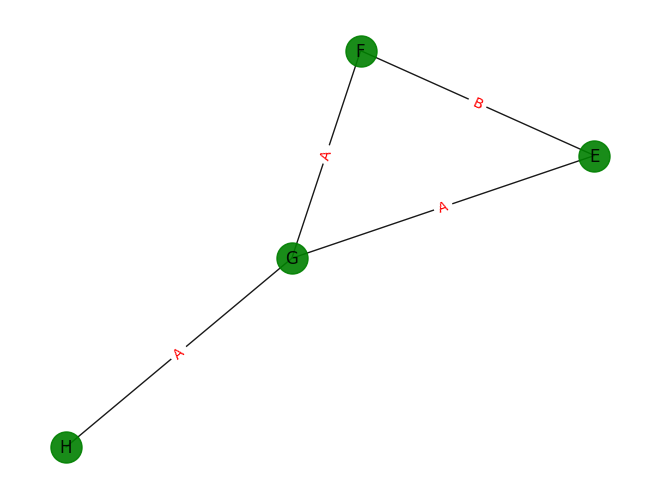

In [224]:
draw_graph_with_labels(G2)

## Without labels

In [225]:
g1_hash = nx.weisfeiler_lehman_graph_hash(G1)
g2_hash = nx.weisfeiler_lehman_graph_hash(G2)

# g1_hash and g2_hash are equal when they are isomorphic
print(f"First  graph hash: {g1_hash}")
print(f"Second graph hash: {g2_hash}")
print(f"Checking graph isomorphic: {g1_hash==g2_hash}")

First  graph hash: 7bc4dde9a09d0b94c5097b219891d81a
Second graph hash: 7bc4dde9a09d0b94c5097b219891d81a
Checking graph isomorphic: True


## With node labels

In [226]:
g1_hash = nx.weisfeiler_lehman_graph_hash(G1, node_attr="label")
g2_hash = nx.weisfeiler_lehman_graph_hash(G2, node_attr="label")

# g1_hash and g2_hash are equal when they are isomorphic
print(f"First  graph hash: {g1_hash}")
print(f"Second graph hash: {g2_hash}")
print(f"Checking graph isomorphic: {g1_hash==g2_hash}")

First  graph hash: abb9c9a6d96be14ce46c54fd8caea3ef
Second graph hash: ce744a670d85f44bb0e504754ef4d70d
Checking graph isomorphic: False


## With edge labels

In [227]:
g1_hash = nx.weisfeiler_lehman_graph_hash(G1, edge_attr="label")
g2_hash = nx.weisfeiler_lehman_graph_hash(G2, edge_attr="label")

# g1_hash and g2_hash are equal when they are isomorphic
print(f"First  graph hash: {g1_hash}")
print(f"Second graph hash: {g2_hash}")
print(f"Checking graph isomorphic: {g1_hash==g2_hash}")

First  graph hash: c653d85538bcf041d88c011f4f905f10
Second graph hash: 3dcd84af1ca855d0eff3c978d88e7ec7
Checking graph isomorphic: False
